<a href="https://colab.research.google.com/github/HannaRF/GAN-and-Autoencoder/blob/main/GAN_and_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Programming Assignment 4: GANs+Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The idea of this assignment is to compare autoencoders, variational autoencoders and generative adversarial networks for data synthesis. You will implement (or use the implementation provided in the Lab classes) these three models and compare the results of data synthesis for training and testing samples, and also for stochastic synthesis, where you synthesize from random noise. The auxiliary functions are provided in the codes from the Lab classes. The dataset to evaluate is the fashion MNIST.

The results should be structured considering the three different models (GANs, Autoencoders and Variational Autoencoders) and the three synthesis configurations (training, testing, stoachastic). You should comment on the differences observed between models and also how the model performs considering each synthesis configuration. You should also discuss why and how the behavior observed is linked to the theorethical background for each model seen in class, i.e., you need to justify how the model characteristics justify the results observed.

You can find template codes for autoencoders and GANs in the lab classes and for variational autoencoders in the keras tutorial: https://keras.io/examples/generative/vae.


As the task outcome, you need to deliver the code and a report with the discussion mentioned above.

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from IPython import display
import os
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy

In [ ]:

# === Change the code here === #
filter_multiplier = 1


## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder (latent dimensions = 2)
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
latent_dim = 2

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0672 - val_loss: 0.0577
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0543 - val_loss: 0.0507
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0484 - val_loss: 0.0462
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0453 - val_loss: 0.0446
Epoch 5/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0443 - val_loss: 0.0442
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0443 - val_loss: 0.0441
Epoch 8/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0442 - val_loss: 0.0441
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0442 - val_loss: 0.0440
Epoch 10/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.044

Now that the model is trained, let's test it by encoding and decoding images from the test set.

### Resultados no conjunto de treino

In [ ]:
encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

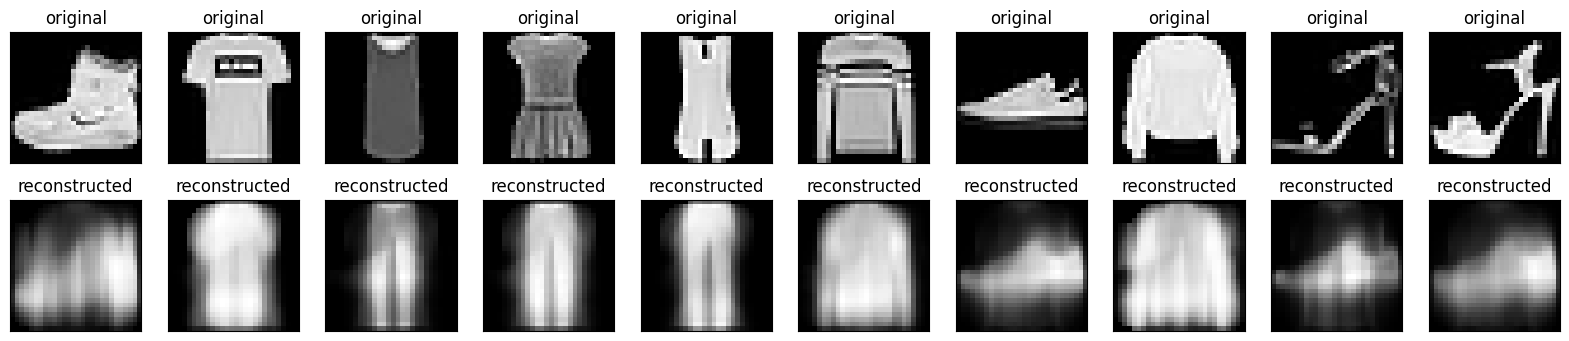

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Resultados no conjunto de teste

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

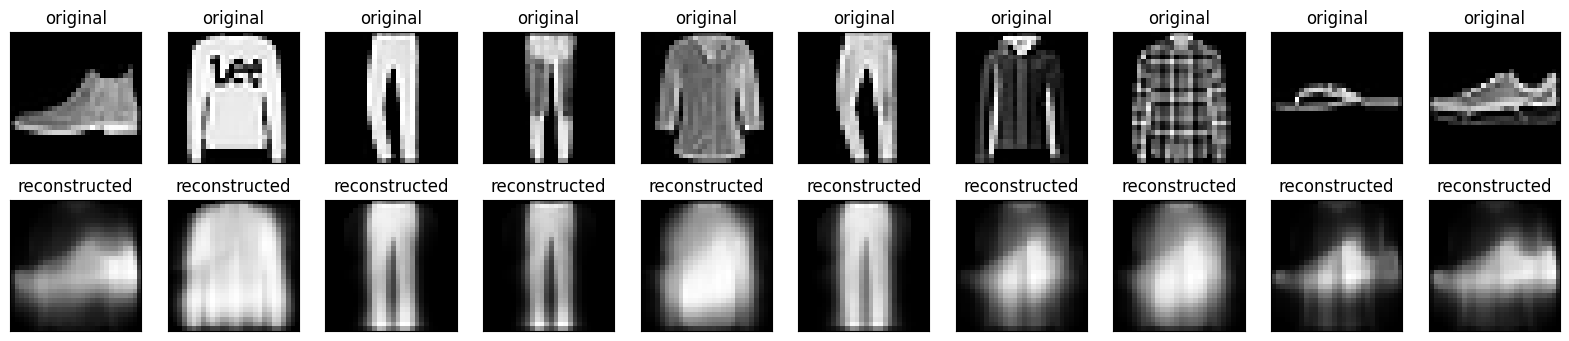

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

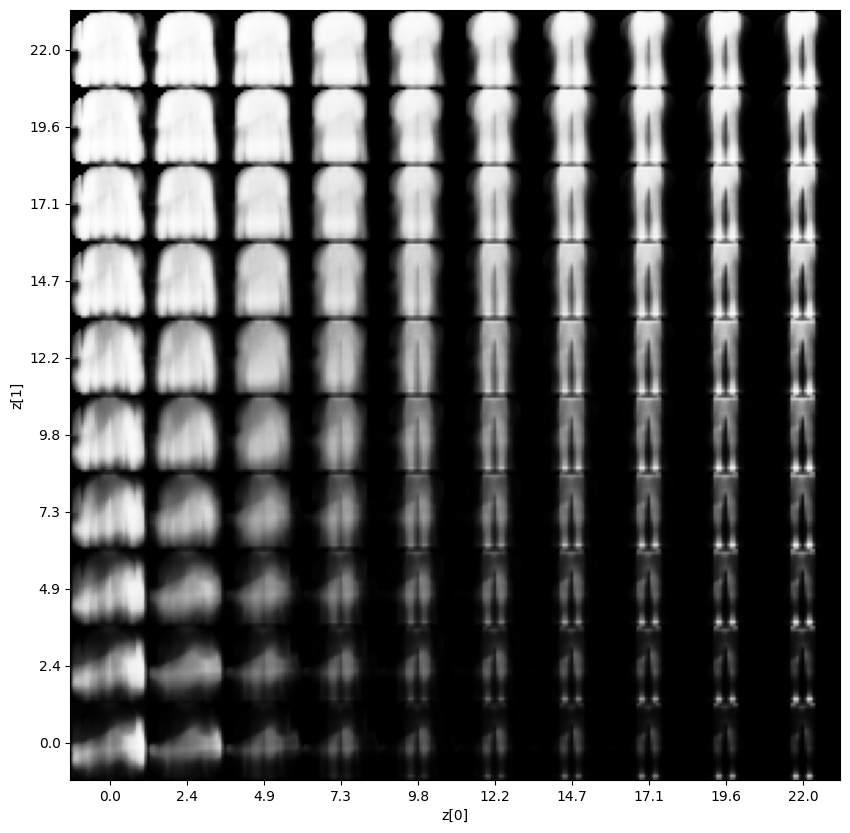

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(model, n=10, figsize=10):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 5
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(0, 22, n)
    grid_y = np.linspace(0, 22, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = model.decoder(z_sample).numpy()
            digit = x_decoded.reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(autoencoder)

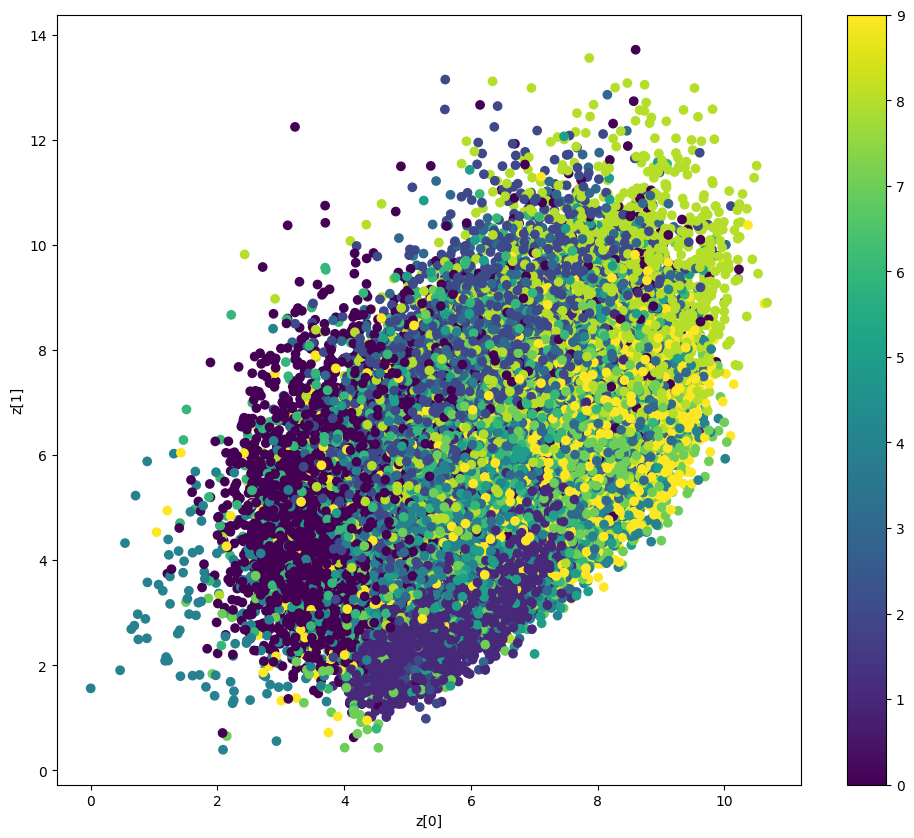

In [ ]:
def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z = model.encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="viridis")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(autoencoder, x_train, y_train)

# Basic Autoencoder (latent dimensions = 64)

In [ ]:
latent_dim = 64

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=30,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
1875/1875 [==============================] - 14s 5ms/step - loss: 0.0240 - val_loss: 0.0136
Epoch 2/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 5/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.00

### Resultados no conjunto de treino

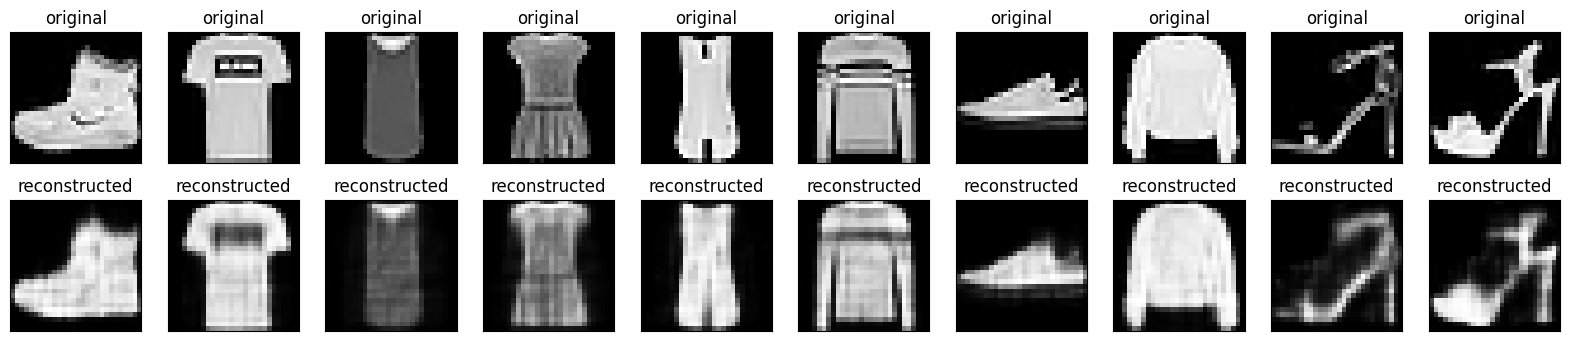

In [ ]:
encoded_imgs = autoencoder.encoder(x_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Resultados no conjunto de teste

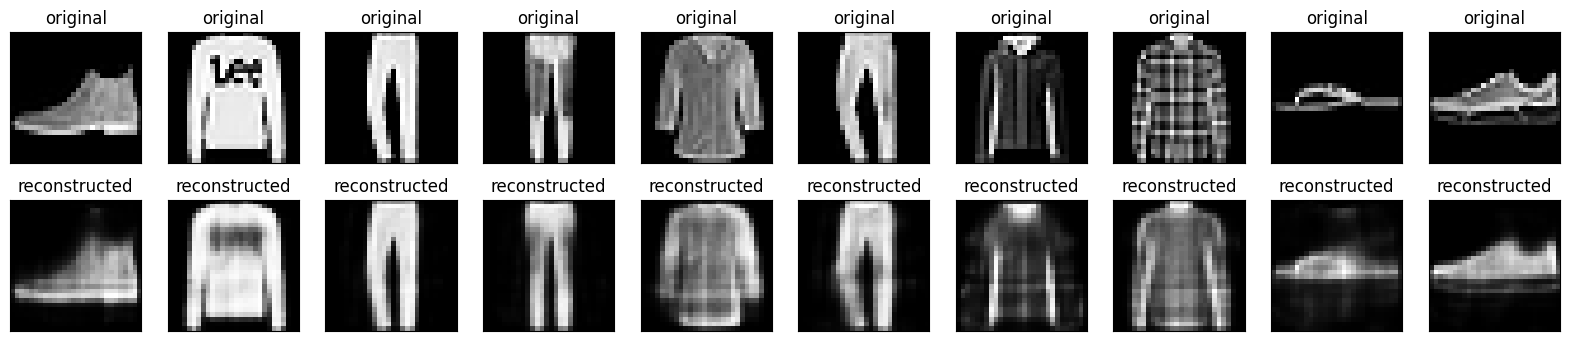

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoder (latent dimensions = 2)

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def set_encoder_decoder_models(latent_dim):
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

  return encoder, decoder

encoder, decoder = set_encoder_decoder_models(2)

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
# (x_train, _), (x_test, _) = fashion_mnist.load_data()
mnist_fashion = np.concatenate([x_train, x_test], axis=0)
mnist_fashion = np.expand_dims(mnist_fashion, -1).astype("float32") #/ 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_fashion, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 18s 9ms/step - loss: 390.8531 - reconstruction_loss: 346.7383 - kl_loss: 8.1493
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 327.0503 - reconstruction_loss: 314.9644 - kl_loss: 10.0344
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 317.9122 - reconstruction_loss: 306.9721 - kl_loss: 9.3206
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 311.3766 - reconstruction_loss: 302.5040 - kl_loss: 8.4026
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 308.5420 - reconstruction_loss: 300.1369 - kl_loss: 8.0107
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 306.9539 - reconstruction_loss: 298.8236 - kl_loss: 7.7343
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 305.4853 - reconstruction_loss: 297.5377 - kl_loss: 7.5287
Epoch 8/30
547/547 [==============================] - 4s 8ms/step -

### rascunho

1/1 [==============================] - 0s 19ms/step


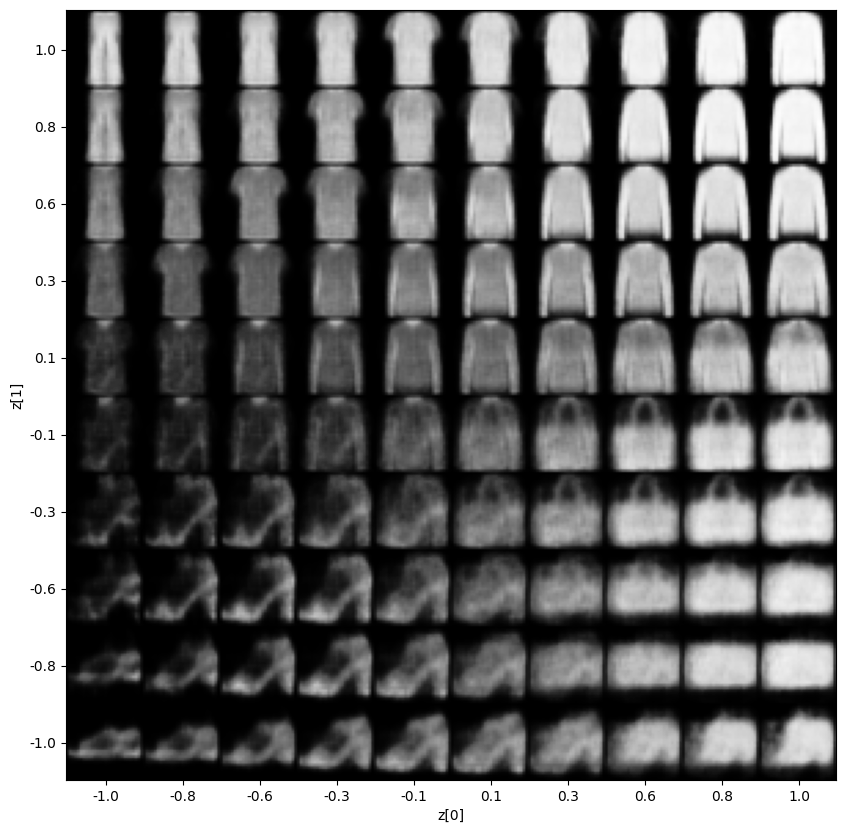

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=10):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1875/1875 [==============================] - 5s 2ms/step


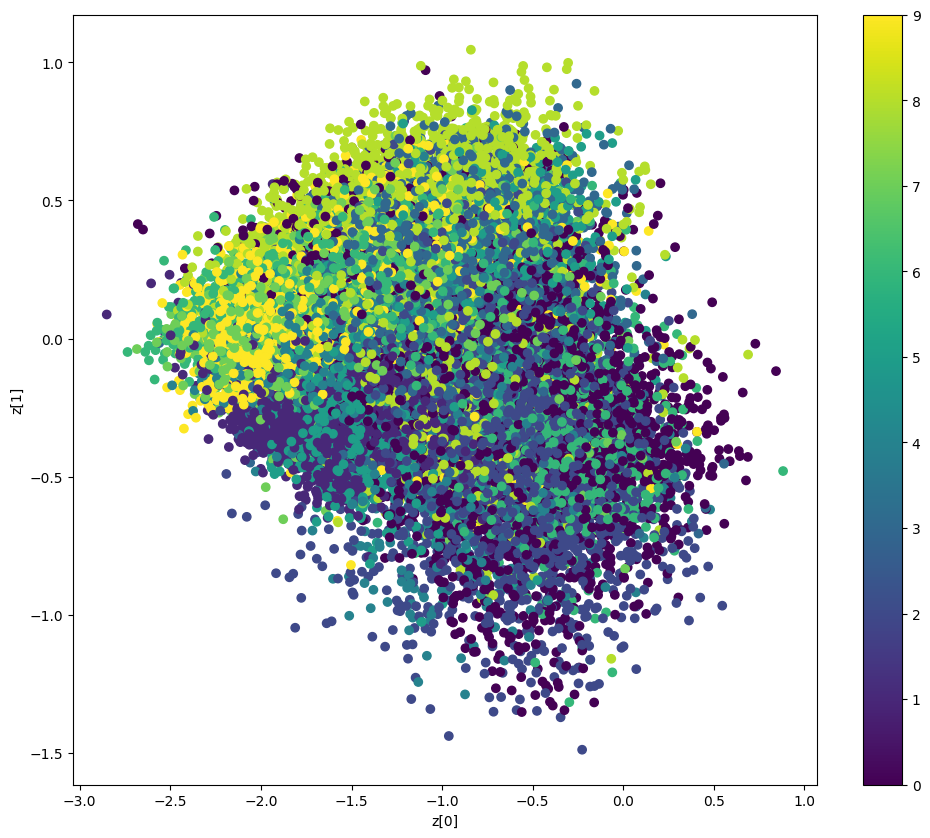

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="viridis")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

### Resultados no conjunto de treino

In [ ]:
z_mean, z_log_var, z = vae.encoder(x_train[:10])
reconstruction = vae.decoder(z)

encoded_imgs = z.numpy()
decoded_imgs = reconstruction.numpy().reshape((10, 28, 28))

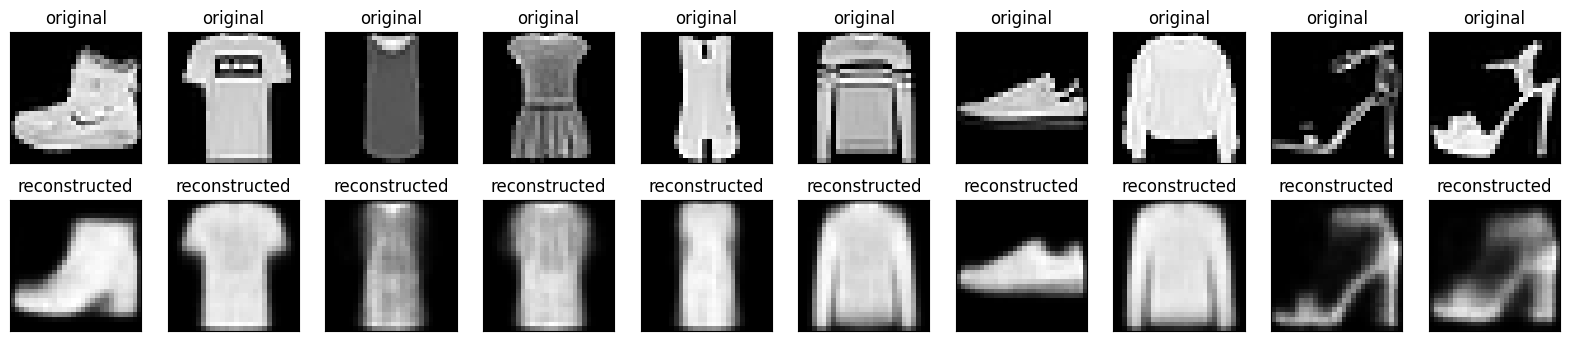

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Resultados no conjunto de teste

In [ ]:
z_mean, z_log_var, z = vae.encoder(x_train[:10])
reconstruction = vae.decoder(z)

encoded_imgs = z.numpy()
decoded_imgs = reconstruction.numpy().reshape((10000, 28, 28))

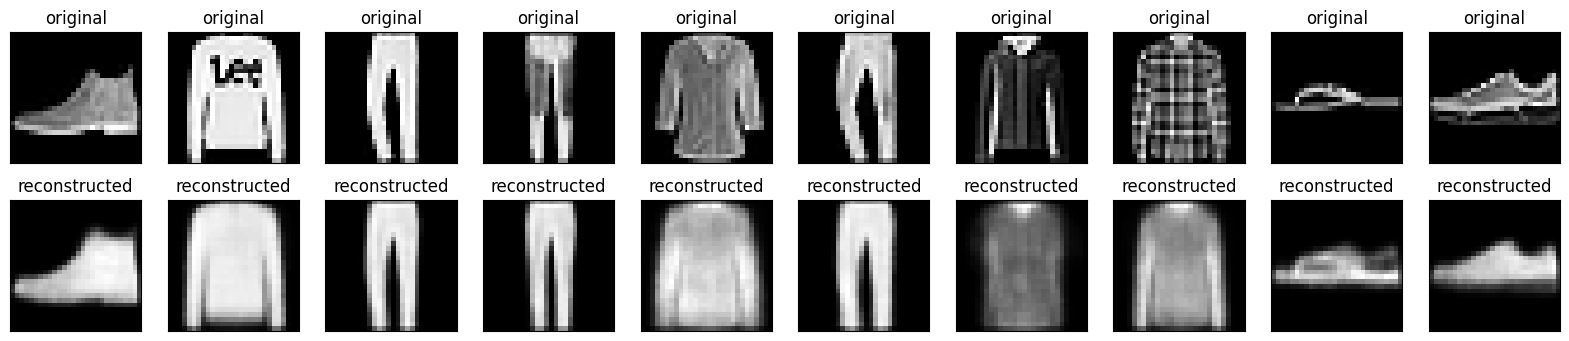

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Variational Autoencoder (latent dimensions = 64)

In [ ]:
encoder, decoder = set_encoder_decoder_models(64)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_fashion, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 7s 9ms/step - loss: 398.0968 - reconstruction_loss: 356.7788 - kl_loss: 5.4683
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 326.5522 - reconstruction_loss: 315.4889 - kl_loss: 9.2340
Epoch 3/30
547/547 [==============================] - 4s 8ms/step - loss: 318.2008 - reconstruction_loss: 307.6009 - kl_loss: 8.8248
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 311.7481 - reconstruction_loss: 302.9282 - kl_loss: 8.4178
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 308.7799 - reconstruction_loss: 300.2373 - kl_loss: 7.7487
Epoch 6/30
547/547 [==============================] - 4s 8ms/step - loss: 305.9346 - reconstruction_loss: 298.4748 - kl_loss: 7.3500
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 304.6459 - reconstruction_loss: 297.1447 - kl_loss: 7.2127
Epoch 8/30
547/547 [==============================] - 4s 8ms/step - l

### Resultados no conjunto de treino

In [ ]:
# (x_train, _), (x_test, _) = fashion_mnist.load_data()
mnist_fashion = np.concatenate([x_train, x_test], axis=0)
mnist_fashion = np.expand_dims(mnist_fashion, -1).astype("float32") #/ 255

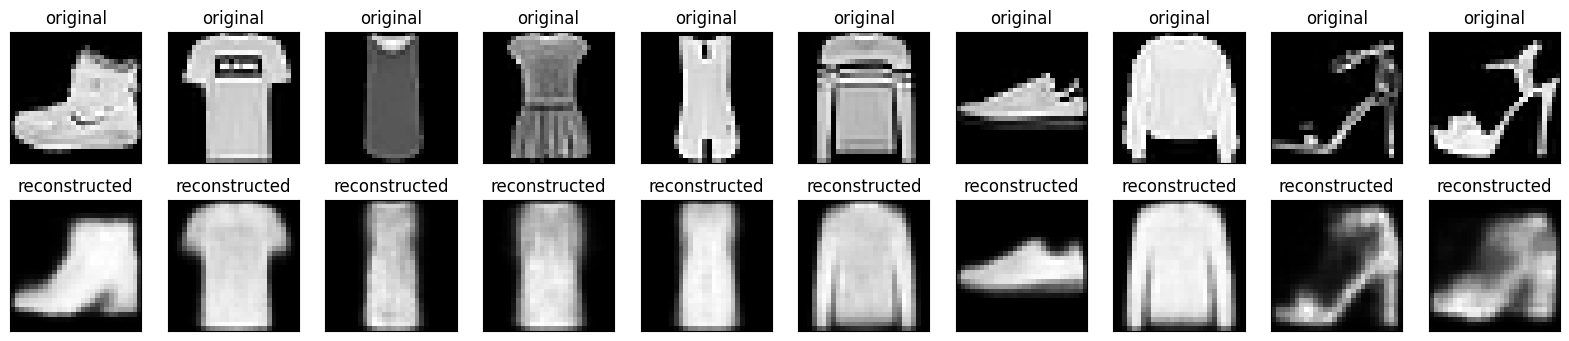

In [ ]:
z_mean, z_log_var, z = vae.encoder(x_train[:10])
reconstruction = vae.decoder(z)

encoded_imgs = z.numpy()
decoded_imgs = reconstruction.numpy().reshape((10, 28, 28))

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Resultados no conjunto de teste

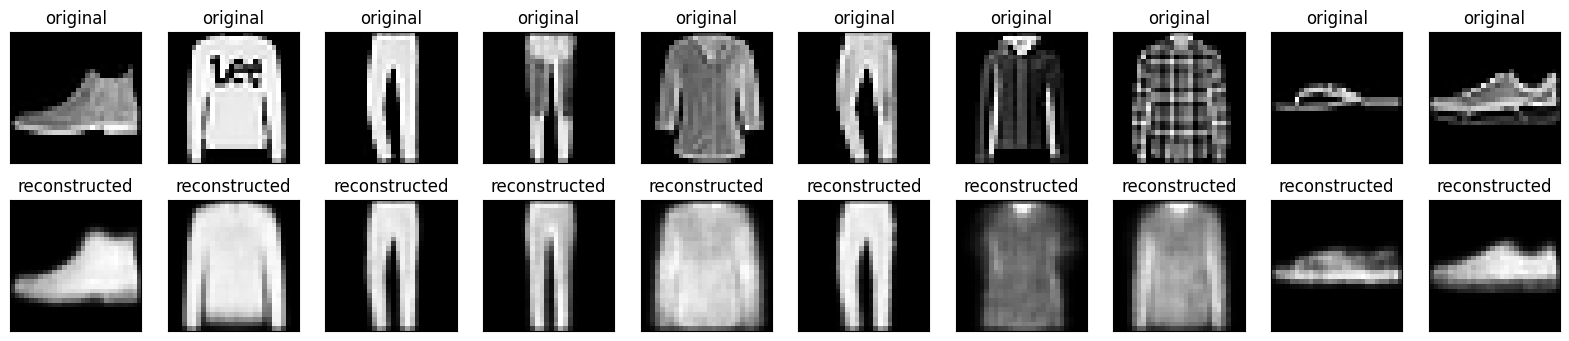

In [ ]:
z_mean, z_log_var, z = vae.encoder(x_test)
reconstruction = vae.decoder(z)

encoded_imgs = z.numpy()
decoded_imgs = reconstruction.numpy().reshape((10000, 28, 28))

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


## Generative Adversarial Network



In [ ]:
tf.config.run_functions_eagerly(True)

def make_generator_model(latent_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, noise):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, noise)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## GAN: Noise with standard normal distribution, latent space = 2

In [ ]:
EPOCHS = 30
noise_dim = 2
num_examples_to_generate = 16
BATCH_SIZE = 128

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

discriminator = make_discriminator_model()
generator = make_generator_model(noise_dim)

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
noise = tf.random.normal([BATCH_SIZE, noise_dim])

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

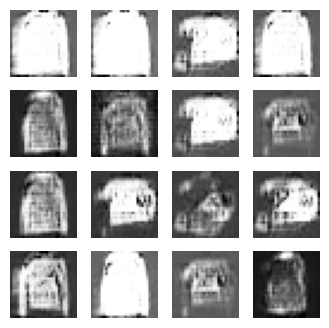

In [ ]:
train(train_dataset, EPOCHS, noise)

## GAN: Noise with normal distribution, latent space = 64

In [ ]:
EPOCHS = 30
noise_dim = 64
num_examples_to_generate = 16
BATCH_SIZE = 128

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

discriminator = make_discriminator_model()
generator = make_generator_model(noise_dim)

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
noise = tf.random.normal([BATCH_SIZE, noise_dim])

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

4422102/4422102 [==============================] - 0s 0us/step


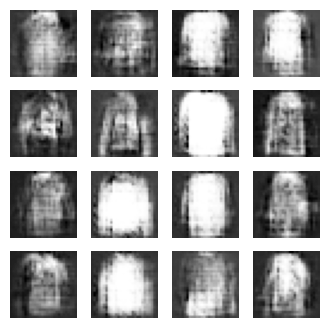

In [ ]:
train(train_dataset, EPOCHS, noise)

## GAN: Noise with uniform distribution, latent space = 2

In [ ]:
EPOCHS = 30
noise_dim = 2
num_examples_to_generate = 16
BATCH_SIZE = 128

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

discriminator = make_discriminator_model()
generator = make_generator_model(noise_dim)

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
noise = tf.random.uniform([BATCH_SIZE, noise_dim])

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

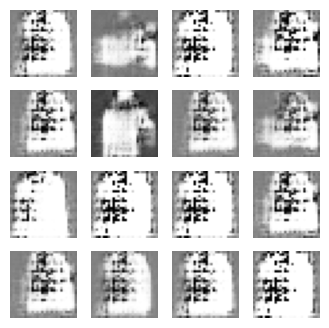

In [ ]:
train(train_dataset, EPOCHS, noise)

## GAN: Noise with uniform distribution, latent space = 64

In [ ]:
EPOCHS = 30
noise_dim = 64
num_examples_to_generate = 16
BATCH_SIZE = 128

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

discriminator = make_discriminator_model()
generator = make_generator_model(noise_dim)

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
noise = tf.random.uniform([BATCH_SIZE, noise_dim])

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

4422102/4422102 [==============================] - 0s 0us/step


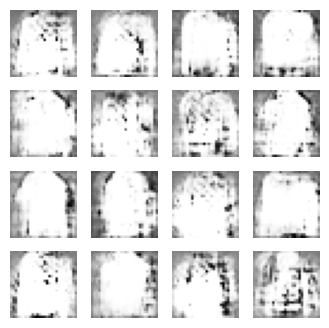

In [ ]:
train(train_dataset, EPOCHS, noise)